In [73]:
import time, csv
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

from random import shuffle

# Preprocessing data

In [74]:
train_data_path = "./dataset/timeseries/RefrigerationDevices/RefrigerationDevices_TRAIN"
test_data_path = "./dataset/timeseries/RefrigerationDevices/RefrigerationDevices_TEST"

In [75]:
train_data, train_label = [], []
with open(train_data_path) as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    train_data.append(row[1:])
    train_label.append(row[0])
      
test_data, test_label = [], []
with open(test_data_path) as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    test_data.append(row[1:])
    test_label.append(row[0])
      

In [76]:
# LENGTH = np.shape(train_data)[1]
LENGTH = 50
TRAIN_ALL_ROWS = np.shape(train_data)[0]
TRAIN_ROWS = 50
TEST_ALL_ROWS = np.shape(test_data)[0]
TEST_ROWS = 10

label_1 = 1
label_2 = 2

## train data

In [77]:
train_data = np.array(train_data, np.float32)
train_label = np.array(train_label, np.float32)
train_label = np.where(train_label == label_2, -1, 1)

index_list = [i for i in range(TRAIN_ALL_ROWS)]
shuffle(index_list)
train_data = train_data[index_list]
train_label = train_label[index_list]

train_data = train_data[:TRAIN_ROWS, :LENGTH]
train_label = train_label[:TRAIN_ROWS]
train_label = train_label.reshape(-1, 1)

## test data

In [78]:
test_data = np.array(test_data, np.float32)
test_label = np.array(test_label, np.float32)
test_label = np.where(test_label == label_2, -1, 1)

index_list = [i for i in range(TRAIN_ALL_ROWS)]
shuffle(index_list)
test_data = test_data[index_list]
test_label = test_label[index_list]

test_data = test_data[:TEST_ROWS, :LENGTH]
test_label = test_label[:TEST_ROWS]
test_label = test_label.reshape(-1, 1)

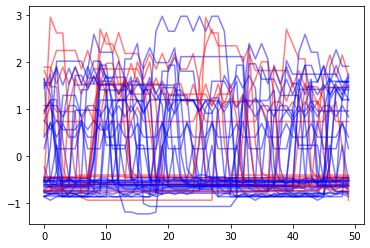

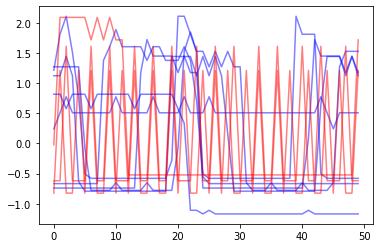

In [79]:
for i in range(TRAIN_ROWS):
  plt.plot(train_data[i].ravel(), 'b' if train_label[i] == 1 else 'r', alpha=0.5)
plt.show()

for i in range(TEST_ROWS):
  plt.plot(test_data[i].ravel(), 'b' if test_label[i] == 1 else 'r', alpha=0.5)
plt.show()

In [80]:
# batch = int(np.shape(train_x)[0] / 2)
batch = TRAIN_ROWS
iter = 5
lr = 0.01
gamma = 25.

In [81]:
X = tf.placeholder(shape=[None, None], dtype=tf.float32)
pred_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
test_X = tf.placeholder(shape=[None, None], dtype=tf.float32)

Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

B = tf.Variable(tf.random_uniform(shape=[1, batch]))

In [82]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [83]:
G = tf.constant(gamma)
dtw_distances = tf.py_function(func=_dtw, inp=[X, X], Tout=[tf.float32 for i in range(batch)])

#kernel = tf.exp(-tf.multiply(G, dtw_distances))
kernel = tf.exp(tf.divide(-tf.square(dtw_distances), tf.square(G)))

In [84]:
first_term = tf.reduce_sum(B)

second_term = tf.reduce_sum(
  tf.multiply(
    kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [85]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X, pred_X], Tout=[tf.float32 for i in range(batch)])
pred_kernel = tf.exp(tf.divide(-tf.square(pred_dtw_distances), tf.square(G)))
#pred_kernel = tf.exp(-tf.multiply(G, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y)), tf.float32))

In [86]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[X, test_X], Tout=[tf.float32 for i in range(batch)])
# test_kernel = tf.exp(-tf.multiply(G, test_dtw_distances))
test_kernel = tf.exp(tf.divide(-tf.square(test_dtw_distances), tf.square(G)))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y)), tf.float32))

In [87]:
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [ ]:
start = time.time()

loss_vec = []
batch_accuracy = []

rand_index = []
for i in range(iter):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(TRAIN_ROWS, size=batch, replace=False)
  rand_x = train_data[rand_index]
  rand_y = train_label[rand_index]

  sess.run(train, feed_dict={X: rand_x, Y: rand_y})
  temp_loss = sess.run(loss, feed_dict={X: rand_x, Y: rand_y})
  loss_vec.append(temp_loss)
  print(B.eval(sess))
  acc_temp = sess.run(accuracy, feed_dict={X: rand_x, Y: rand_y, pred_X: rand_x})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
[[0.64869106 0.33012277 0.32565418 0.7895314  0.686378   0.48059133
  0.82069856 0.69689006 0.8755502  0.7570108  0.77201647 0.2866234
  0.7689951  0.2600543  0.87702423 0.55245924 0.86075705 0.59716684
  0.9520294  0.86191213 0.24430993 0.4172268  0.20263107 0.12808135
  1.0141472  0.9101424  0.8198854  0.57175595 0.35603088 0.5228441
  0.67430145 0.31361088 0.21778694 0.5755336  0.2249414  0.68980944
  0.57511026 0.31569767 0.27210993 0.64147246 0.19052929 0.68573433
  0.57007474 0.96596473 0.5062831  0.25656337 0.60814345 0.8862576
  0.79987884 0.33021596]]
accuracy : 0.62
loss: 11.865831
time : 85.30977392196655
Step #2
[[0.6377841  0.26870224 0.22753835 0.7169843  0.7532469  0.47945178
  0.77372825 0.7491383  0.77806026 0.6936543  0.6826695  0.3007025
  0.80739427 0.29467037 0.9582724  0.492697   0.7743925  0.50453895
  1.0369188  0.9114161  0.1994608  0.33814344 0.19950145 0.11762252
  1.0643657  0.8608268  0.77279705 0.5166973  0.26543048 0.44612712
  0.6971422  0.400002

In [ ]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [ ]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          X: train_data[rand_index],
                          Y: train_label[rand_index],
                          test_X: test_data
                      })

print(test_preds)
print(test_label)

In [ ]:
test_acc = sess.run(test_accuracy,
                      feed_dict={
                          X: train_data[rand_index],
                          Y: train_label[rand_index],
                          test_X: test_data,
                          test_Y: test_label
                      })
print(test_acc)


## Influence function

### Gradient for target data

In [ ]:
inf_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[X, inf_X], Tout=[tf.float32 for i in range(batch)])
# inf_kernel = tf.exp(-tf.multiply(G, inf_dtw_distances))
inf_kernel = tf.exp(tf.divide(-tf.square(inf_dtw_distances), tf.square(G)))


In [ ]:
inf_first_term = tf.reduce_sum(B)
inf_second_term = tf.reduce_sum(
  tf.multiply(
    inf_kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))

grad_op = tf.gradients(inf_loss, [B])
hess_op = tf.hessians(inf_loss, [B])

In [ ]:
a = sess.run(grad_op,
             feed_dict={
               X: train_data[rand_index],
               Y: train_label[rand_index],
               inf_X: [test_data[1]]
             })

print(a)

In [ ]:
def get_inf(test_index):
  print('test index is ', test_index, 'test_label is ', test_label[test_index])
  print(rand_index)

  z_test_grad = sess.run(grad_op, feed_dict={
    X: train_data[rand_index],
    Y: train_label[rand_index],
    inf_X: [test_data[test_index]]
  })
  z_test_grad = np.squeeze(z_test_grad)
  print(z_test_grad)
  hess = sess.run(hess_op, feed_dict={
    X: train_data[rand_index],
    Y: train_label[rand_index],
    inf_X: train_data
  })

  hess = np.squeeze(hess)
  inv_hess = np.linalg.inv(hess)

  infs = []

  for i in range(len(rand_index)):
    train_index = rand_index[i]
    train_grad = sess.run(grad_op,
                          feed_dict={
                            X: train_data[rand_index],
                            Y: train_label[rand_index],
                            inf_X: [train_data[train_index]]
                          })

    train_grad = np.squeeze(train_grad)
    z_hess_grad = np.matmul(inv_hess, train_grad)
    inf_val = -(np.matmul(z_test_grad, z_hess_grad) / TRAIN_ROWS)

    infs.append((train_index, inf_val))
    # dist = fastdtw(train_data[train_index], test_data[test_index], dist=euclidean)[0]
    # infs.append((train_index, test_index, inf_val, dist))

  infs = sorted(infs, key=lambda x: x[1])
  return infs

In [ ]:
infs = []
for i in range(TEST_ROWS):
  infs.append(get_inf(i))

# infs = get_inf(0)

In [ ]:
print(np.array(infs))

In [ ]:
inf_cnt = 1
for i in range(len(infs)):
  inf = infs[i]
  for j in range(len(inf)):
    train_index = inf[j][0]
    test_index = inf[j][1]

    alpha = 0.1
    color = 'k'
    if j < inf_cnt:
      color = 'r'
      alpha = 1.
    elif j > TRAIN_ROWS - inf_cnt - 1:
      color = 'b'
      alpha = 1.

    plt.plot(train_data[train_index], color, alpha=alpha)

  print('test index is ', inf[0][1])
  plt.show()
